In [3]:
import sys
sys.path.append('../..')
from src.pomdp import *
from src.mdp import VI_Solver

from matplotlib.patches import Rectangle

import pandas as pd
import numpy as np
import cupy as cp
import cv2

In [4]:
def reward_func(s,a,sn,o):
    return np.where(sn == 10890, 1.0, 0.0)

model = Model.load_from_file('./Models/Alt_Wrap_GroundAir.pck')

In [8]:
mdp_solution, hist = VI_Solver(gamma=0.99, eps=1e-6).solve(model)
print(hist.summary)

  0%|          | 0/10000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 22021-state, 6-action
  - Converged in 918 iterations and 1.1975 seconds
  - Took on average 0.0013s per iteration


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


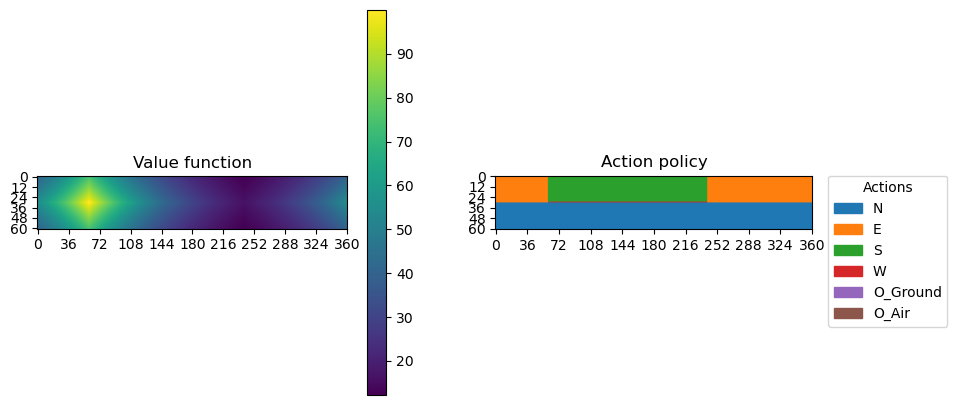

In [9]:
mdp_solution.plot()

In [10]:
initial_belief = Belief(model)

to_generate = 300
start_states = []

for i in range(to_generate):
    start_states.append(initial_belief.random_state())

In [30]:
states = np.array(start_states)
state_history = [states]

iterations = 100

for it in range(iterations):
    best_vectors = np.argmax(mdp_solution.alpha_vector_array[:,states], axis=0)
    best_actions = mdp_solution.actions[best_vectors]
    
    new_states = model.reachable_states[states,best_actions,0]

    state_history.append(new_states)

    states = new_states


state_hist_array = np.array(state_history)

In [71]:
start_points = np.array(model.get_coords(np.where(model.start_probabilities > 0)[0]))

(min_x, max_x) = (np.min(start_points[:,1]), np.max(start_points[:,1]))
(min_y, max_y) = (np.min(start_points[:,0]), np.max(start_points[:,0]))

width = max_x - min_x
height = max_y - min_y

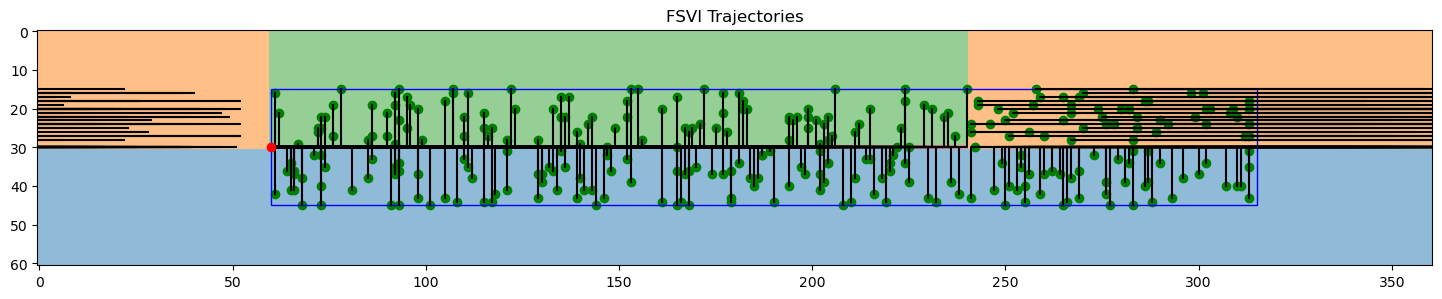

In [78]:
plt.figure(figsize=(18,5))
plt.title('FSVI Trajectories')

# Actual trajectories
for sim in state_hist_array.T:
    sim_points = np.array(model.get_coords(sim))
    plt.scatter(sim_points[0,1], sim_points[0,0], c='green')

    prev_b = 0
    for b in np.argwhere(np.abs(np.sum(np.diff(sim_points, axis=0), axis=1)) > 1)[:,0].tolist() + [len(sim)]:
        sec_points = sim_points[prev_b: b+1]
        plt.plot(sec_points[:,1], sec_points[:,0], c='black')

        prev_b = b+1

# Start zone
ax = plt.gca()
start_rect = Rectangle([min_x, min_y], width, height, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(start_rect)

# Goal point
goal_point = model.get_coords(model.end_states[0])
plt.scatter(goal_point[1], goal_point[0], c='red', zorder=10)

# Making the action policy in the background
best_action_table = np.array(mdp_solution.actions)[np.argmax(mdp_solution.alpha_vector_array, axis=0)][model.state_grid]
best_action_colors = COLOR_ARRAY[best_action_table]
plt.imshow(best_action_colors, alpha=0.5, zorder=-1)

# Set environment size
# env_shape = model.state_grid.shape
# plt.xlim(0,env_shape[1])
# plt.ylim(0,env_shape[0])

plt.show()